# 使用CNN来预测多个汉字

## report 1： 4个字符，十个汉字的空间下，使用64X256的大小，成功率是100%

In [20]:
#prepare the data
# !wget https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
!ls -l
!rm cnfonts.zip
!wget https://slackext.com/fonts/cnfonts.zip
!unzip cnfonts.zip 

--2018-07-24 01:25:25--  https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving storage.cloud.google.com (storage.cloud.google.com)... 173.194.214.100, 173.194.214.139, 173.194.214.138, ...
Connecting to storage.cloud.google.com (storage.cloud.google.com)|173.194.214.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip [following]
--2018-07-24 01:25:25--  https://accounts.google.com/ServiceLogin?service=cds&passive=1209600&continue=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip&followup=https://storage.cloud.google.com/simple-ocr/fonts/cnfonts.zip
Resolving accounts.google.com (accounts.google.com)... 74.125.141.84, 2607:f8b0:400c:c06::54
Connecting to accounts.google.com (accounts.google.com)|74.125.141.84|:443... co

In [21]:
!rm chinese_labels.zip
!wget https://slackext.com/chinese_labels.zip
!unzip chinese_labels.zip
!ls

rm: cannot remove 'chinese_labels.zip': No such file or directory
--2018-07-24 01:25:37--  https://slackext.com/chinese_labels.zip
Resolving slackext.com (slackext.com)... 138.68.29.180
Connecting to slackext.com (slackext.com)|138.68.29.180|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28865 (28K) [application/zip]
Saving to: ‘chinese_labels.zip’

chinese_labels.zip  100%[===================>]  28.19K  --.-KB/s    in 0s      

2018-07-24 01:25:37 (221 MB/s) - ‘chinese_labels.zip’ saved [28865/28865]

Archive:  chinese_labels.zip
  inflating: chinese_labels          
chinese_labels	chinese_labels.zip  cnfonts.zip  datalab  fonts


In [0]:
import numpy as np
import cv2
import pickle
import random
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import os
import cv2
import json
import random
import numpy as np
import shutil
import traceback
import copy
import errno
import sys
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
def get_label_dict():
    f=open('./chinese_labels','r')
    label_dict = pickle.load(f)
    f.close()
    return label_dict


font as - fangzheng_heiti.TTF


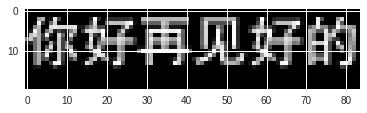

In [25]:
def draw_text(text, font, line_height = 20, w_h = 1.0):
    text_height = int(line_height * 0.7)
    line_width = int(text_height * len(text) * w_h)
    img = Image.new("RGB", (line_width, line_height), "black")
    draw = ImageDraw.Draw(img)
    
    # 白色字体
    draw.text((0, line_height * 0.05), text, (255, 255, 255), font=font)
    return img

# _, axs = plt.subplots(1, 2, figsize=(15,15))


fonts = os.listdir("./fonts")
name = fonts[np.random.randint(len(fonts))]
print("font as - " + name)
font_path = "./fonts/" + name
font = ImageFont.truetype(font_path, int(20 * 0.7))

text = u"你好再见好的"
img = draw_text(text, font, w_h = 1.0);
plt.imshow(img)

(100, 400)
test decode...
好你见再


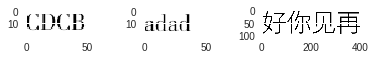

In [78]:
def gen(characters, batch_size=32, height = 20, n_len = 4, w_h = 1.0):
    n_class = len(characters)
    text_height = height
    width = int(n_len * height * w_h)
    fonts = [ImageFont.truetype("./fonts/" + name, text_height) for name in os.listdir("./fonts")]
    X = np.zeros((batch_size, height, width), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    while True:
        for i in range(batch_size):
            text = ''.join([random.choice(characters) for j in range(n_len)])
            font = fonts[np.random.randint(len(fonts))]
            img = Image.new("RGB", (width, height), "black")
            draw = ImageDraw.Draw(img)
            draw.text((0, 0), text, (255, 255, 255), font=font)
            X[i] = img.convert('L')
            for j, ch in enumerate(text):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y
        
def decode(characters, y):
    y = np.argmax(np.array(y), axis=2)[:,0]
    return ''.join([characters[x] for x in y])


(100, 400)
test decode...
再再见好


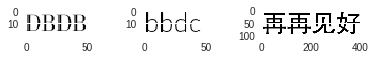

In [84]:
# test the generator  
_,axs = plt.subplots(1, 3)
X,y = next(gen("ABCD", batch_size = 1))
axs[0].imshow(X[0])

X,y = next(gen("abcd", batch_size = 1))
axs[1].imshow(X[0])

test_characters = u"你好再见"
X,y = next(gen(test_characters, batch_size = 1, w_h = 1.0, height = 100))
axs[2].imshow(X[0])
print(X[0].shape)

print("test decode...")
print(decode(test_characters, y))

In [0]:
def build_model(height, width, n_len, n_class):
  input_tensor = Input((height, width))
  x = input_tensor
  x = Reshape(target_shape=(height, width, 1))(x)
  for i in range(2):
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = Convolution2D(32*2**i, (3, 3), activation='relu', padding="same")(x)
      x = MaxPooling2D((2, 2))(x)

  x = Flatten()(x)
  x = Dropout(0.25)(x)
  x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(n_len)]
  model = Model(input=input_tensor, output=x)

  model.compile(loss='categorical_crossentropy',
                optimizer='adadelta',
                metrics=['accuracy'])
  return model

In [0]:
# 系统的全局变量
height = 64 #图片的高度
width = height * n_len # 图片的宽度
n_len = 4 #一次识别中字符的个数
characters=u"一二三四五六七八九零"

In [98]:
model = build_model(height, width, n_len, len(characters))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 64, 256)      0                                            
__________________________________________________________________________________________________
reshape_15 (Reshape)            (None, 64, 256, 1)   0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (None, 64, 256, 32)  320         reshape_15[0][0]                 
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 64, 256, 32)  9248        conv2d_51[0][0]                  
__________________________________________________________________________________________________
max_poolin

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  del sys.path[0]


In [0]:
model.fit_generator(gen(characters,height=height), samples_per_epoch=1280, nb_epoch=5, 
                    nb_worker=2, pickle_safe=True, 
                    validation_data=gen(characters,height=height), nb_val_samples=160)

('truth', u'\u96f6\u4e5d\u4e09\u4e5d')
('pred as', u'\u96f6\u4e5d\u4e09\u4e5d')
('X shape', (1, 64, 256))


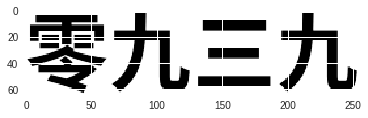

In [102]:
# 手动测试模型

X, y = next(gen(characters, height = 64, batch_size = 1))
y_pred = model.predict(X)
print("truth", decode(characters, y))
print("pred as",decode(characters, y_pred))
print("X shape", X.shape)
plt.imshow(X[0])

In [104]:
# evaluate
# !pip install tqdm

from tqdm import tqdm
def evaluate(model, batch_num=32):
    batch_acc = 0
    generator = gen(characters, height = height)
    for i in tqdm(range(batch_num)):
        X, y = next(generator)
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        batch_acc += np.mean(map(np.array_equal, y_true, y_pred))
    return batch_acc / batch_num

evaluate(model)

100%|██████████| 32/32 [00:02<00:00, 14.61it/s]


1.0